In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import traceback
import os
import pathlib
from keras_preprocessing.image import ImageDataGenerator
# from keras.layers import Input
# from keras.layers import Conv2D, MaxPool2D, Dense, BatchNormalization, Activation, add, GlobalAvgPool2D
# from keras.models import Model
# from keras import regularizers
# from keras.utils import plot_model
# from keras import backend as K
# from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
# from keras.layers import Conv2D, MaxPooling2D
# from keras import regularizers, optimizers
# from keras.models import Sequential, load_model
# from keras.preprocessing.image import load_img, img_to_array

## Load data

In [2]:
train_df = pd.read_csv('./data/train_merge.csv')
val_df = pd.read_csv('./data/val_merge.csv')

In [4]:
# network parameters
sample_train= 6000
sample_val  = 6000
image_size  = 256
input_shape = (image_size, image_size, 3)
batch_size  = 36
epochs      = 50

kernel_size = 3
filters     = 16
latent_dim  = 128

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

NameError: name 'ImageDataGenerator' is not defined

In [49]:
train_df = train_df.sample(sample_train) 
val_df  = val_df.sample(sample_val)
train_df['class'] = train_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)

In [50]:
train_df.shape, val_df.shape

((6000, 3), (6000, 3))

In [51]:
train_dir = './data/train_set'
val_dir = './data/val_set'

In [52]:
train_generator = train_datagen.flow_from_dataframe(
                train_df,
                x_col='img_name',
                y_col='class',    
                class_mode='input',
                directory=train_dir,  # this is the target directory
                shuffle = True,
                target_size=(256, 256),  # all images will be resized to 150x150
                batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary labels

test_generator = test_datagen.flow_from_dataframe(
                val_df,
                x_col='img_name',
                y_col='class',    
                class_mode='input',
                directory= val_dir,  # this is the target directory
                shuffle = False,
                target_size=(256, 256),  # all images will be resized to 150x150
                batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary label
# Predict train 
train_generator_inf = test_datagen.flow_from_dataframe(
                        train_df,
                        x_col='img_name',
                        y_col='class',    
                        class_mode='input',
                        directory=train_dir,  # this is the target directory
                        shuffle = False,
                        target_size=(256, 256),  # all images will be resized to 150x150
                        batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary labels

Found 6000 validated image filenames.
Found 6000 validated image filenames.
Found 6000 validated image filenames.


In [53]:
train_generator.next()

(array([[[[0.2243156 , 0.00470774, 0.00235387],
          [0.2312535 , 0.00784314, 0.00392157],
          [0.23529413, 0.00784314, 0.00392157],
          ...,
          [0.7349011 , 0.03450795, 0.00706161],
          [0.73948514, 0.0381006 , 0.        ],
          [0.746423  , 0.03595659, 0.        ]],
 
         [[0.2243156 , 0.00470774, 0.00235387],
          [0.2312535 , 0.00784314, 0.00392157],
          [0.23529413, 0.00784314, 0.00392157],
          ...,
          [0.7349011 , 0.03450795, 0.00706161],
          [0.73948514, 0.0381006 , 0.        ],
          [0.746423  , 0.03595659, 0.        ]],
 
         [[0.2243156 , 0.00470774, 0.00235387],
          [0.2312535 , 0.00784314, 0.00392157],
          [0.23529413, 0.00784314, 0.00392157],
          ...,
          [0.7349011 , 0.03450795, 0.00706161],
          [0.73948514, 0.0381006 , 0.        ],
          [0.746423  , 0.03595659, 0.        ]],
 
         ...,
 
         [[0.08627451, 0.        , 0.00784314],
          [0.08627

In [55]:
train_df.img_name.values.shape

(6000,)

## Visulization

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(w, h))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = train_generator.next()[0][0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [42]:
labels = (train_generator.class_indices)
label = dict((v,k) for k,v in labels.items())

In [12]:
num_classes = 251

In [18]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
activation_6 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
__________

In [19]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size

In [20]:
STEP_SIZE_TRAIN

1000

In [21]:
model.compile(optimizer='adam', loss="categorical_crossentropy",metrics=["accuracy"])

In [22]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5
                   )

Epoch 1/5
1000/1000 [==============================] - 2700s 3s/step - loss: 16.0467 - acc: 0.0037 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 2/5
1000/1000 [==============================] - 2635s 3s/step - loss: 16.0657 - acc: 0.0033 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 3/5
1000/1000 [==============================] - 2627s 3s/step - loss: 16.0680 - acc: 0.0031 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 4/5
1000/1000 [==============================] - 2677s 3s/step - loss: 16.0688 - acc: 0.0031 - val_loss: 16.0375 - val_acc: 0.0050
Epoch 5/5
1000/1000 [==============================] - 2816s 3s/step - loss: 16.0639 - acc: 0.0034 - val_loss: 16.0375 - val_acc: 0.0050


In [23]:
model.save('cnnmodel.hdf5')
model.save('cnnmodel.h5')

In [25]:
val_df = pd.read_csv('./data/val_merge.csv')

In [64]:
val_df

,img_name,label,class
0,val_010323.jpg,247,eccles_cake
1,val_010350.jpg,247,eccles_cake
2,val_010389.jpg,247,eccles_cake
3,val_010404.jpg,247,eccles_cake
4,val_010471.jpg,247,eccles_cake
...,...,...,...
11989,val_006665.jpg,189,limpet_food
11990,val_007712.jpg,189,limpet_food
11991,val_008322.jpg,189,limpet_food
11992,val_008666.jpg,189,limpet_food


In [26]:
test_generator = test_datagen.flow_from_dataframe(
                val_df,
                x_col='img_name',
                y_col='class',    
                class_mode='categorical',
                directory= val_dir,  # this is the target directory
                shuffle = False,
                target_size=(256, 256),  # all images will be resized to 150x150
                batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary label

Found 11994 validated image filenames belonging to 251 classes.


In [111]:
a = 2655
img = os.path.join(val_dir, val_df.iloc[a]['img_name'])

In [112]:
img = load_img(img, target_size=(256, 256, 3))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.

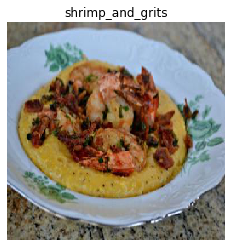

In [113]:
plt.imshow(img[0])
plt.axis('off')
plt.title(val_df.iloc[a]['class'])
plt.show()

In [114]:
pred = model.predict(img)

In [115]:
np.argmax(pred)

224

In [110]:
label[np.argmax(pred)]

'sushi'

In [43]:
val_df[val_df['img_name'] == 'val_010350.jpg']['class'] == label[81]

1    True
Name: class, dtype: bool

In [53]:
test_generator.reset()

In [54]:
test_generator.filenames

['val_010323.jpg',
 'val_010350.jpg',
 'val_010389.jpg',
 'val_010404.jpg',
 'val_010471.jpg',
 'val_010552.jpg',
 'val_010561.jpg',
 'val_010589.jpg',
 'val_010611.jpg',
 'val_010720.jpg',
 'val_010759.jpg',
 'val_010763.jpg',
 'val_010804.jpg',
 'val_010838.jpg',
 'val_010907.jpg',
 'val_010939.jpg',
 'val_010945.jpg',
 'val_010961.jpg',
 'val_011055.jpg',
 'val_011110.jpg',
 'val_011157.jpg',
 'val_011181.jpg',
 'val_011232.jpg',
 'val_011251.jpg',
 'val_011253.jpg',
 'val_011271.jpg',
 'val_011322.jpg',
 'val_011360.jpg',
 'val_011372.jpg',
 'val_011427.jpg',
 'val_011456.jpg',
 'val_011460.jpg',
 'val_011531.jpg',
 'val_011653.jpg',
 'val_011659.jpg',
 'val_011741.jpg',
 'val_011891.jpg',
 'val_011997.jpg',
 'val_012067.jpg',
 'val_012096.jpg',
 'val_012110.jpg',
 'val_012157.jpg',
 'val_012166.jpg',
 'val_010324.jpg',
 'val_010338.jpg',
 'val_010401.jpg',
 'val_010525.jpg',
 'val_010583.jpg',
 'val_010629.jpg',
 'val_010669.jpg',
 'val_010695.jpg',
 'val_010727.jpg',
 'val_010769

In [55]:
img, c = next(test_generator)

In [51]:
img, c = next(test_generator)

In [60]:
test_generator.classes

[81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 170,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 1

In [62]:
a = [81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81]

In [63]:
len(a)

43

In [56]:
np.argmax(c)

81

In [40]:
test_generator.filenames

['val_010323.jpg',
 'val_010350.jpg',
 'val_010389.jpg',
 'val_010404.jpg',
 'val_010471.jpg',
 'val_010552.jpg',
 'val_010561.jpg',
 'val_010589.jpg',
 'val_010611.jpg',
 'val_010720.jpg',
 'val_010759.jpg',
 'val_010763.jpg',
 'val_010804.jpg',
 'val_010838.jpg',
 'val_010907.jpg',
 'val_010939.jpg',
 'val_010945.jpg',
 'val_010961.jpg',
 'val_011055.jpg',
 'val_011110.jpg',
 'val_011157.jpg',
 'val_011181.jpg',
 'val_011232.jpg',
 'val_011251.jpg',
 'val_011253.jpg',
 'val_011271.jpg',
 'val_011322.jpg',
 'val_011360.jpg',
 'val_011372.jpg',
 'val_011427.jpg',
 'val_011456.jpg',
 'val_011460.jpg',
 'val_011531.jpg',
 'val_011653.jpg',
 'val_011659.jpg',
 'val_011741.jpg',
 'val_011891.jpg',
 'val_011997.jpg',
 'val_012067.jpg',
 'val_012096.jpg',
 'val_012110.jpg',
 'val_012157.jpg',
 'val_012166.jpg',
 'val_010324.jpg',
 'val_010338.jpg',
 'val_010401.jpg',
 'val_010525.jpg',
 'val_010583.jpg',
 'val_010629.jpg',
 'val_010669.jpg',
 'val_010695.jpg',
 'val_010727.jpg',
 'val_010769

In [39]:
len(test_generator.classes)

11994

In [29]:
test_generator.class_indices

{'adobo': 0,
 'ambrosia_food': 1,
 'apple_pie': 2,
 'apple_turnover': 3,
 'applesauce': 4,
 'applesauce_cake': 5,
 'baby_back_rib': 6,
 'bacon_and_eggs': 7,
 'bacon_lettuce_tomato_sandwich': 8,
 'baked_alaska': 9,
 'baklava': 10,
 'barbecued_spareribs': 11,
 'barbecued_wing': 12,
 'beef_bourguignonne': 13,
 'beef_carpaccio': 14,
 'beef_stroganoff': 15,
 'beef_tartare': 16,
 'beef_wellington': 17,
 'beet_salad': 18,
 'beignet': 19,
 'bibimbap': 20,
 'biryani': 21,
 'blancmange': 22,
 'boiled_egg': 23,
 'boston_cream_pie': 24,
 'bread_pudding': 25,
 'brisket': 26,
 'bruschetta': 27,
 'bubble_and_squeak': 28,
 'buffalo_wing': 29,
 'burrito': 30,
 'caesar_salad': 31,
 'cannelloni': 32,
 'cannoli': 33,
 'caprese_salad': 34,
 'carbonnade_flamande': 35,
 'carrot_cake': 36,
 'casserole': 37,
 'ceviche': 38,
 'cheesecake': 39,
 'chicken_cordon_bleu': 40,
 'chicken_curry': 41,
 'chicken_kiev': 42,
 'chicken_marengo': 43,
 'chicken_provencale': 44,
 'chicken_quesadilla': 45,
 'chicken_wing': 46,
